In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [28]:

# Define TSP
n_customer = 4
n_point = n_customer + 1

# 재현성을 위한 시드 고정
np.random.seed(0)

# 무작위 좌표 생성
df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})

# 출발점(0번 고객)의 좌표를 (0, 0)으로 고정 — 안전한 방식
df.loc[0, 'x'] = 0
df.loc[0, 'y'] = 0

# 결과 출력
df


,x,y
0,0,0
1,47,83
2,64,21
3,67,36
4,67,87


In [29]:
from scipy.spatial import distance_matrix
#import seaborn as sns
distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values


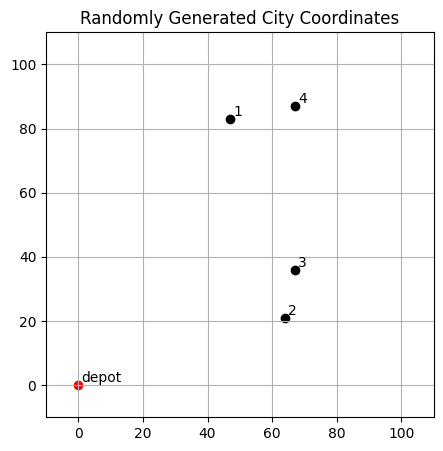

In [30]:
# Check TSP state

plt.figure(figsize=(5, 5))

# Draw the problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
#plt.title('points: id')
plt.title('Randomly Generated City Coordinates')
plt.grid(True)
plt.show()

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def check(n_point, df):
    N = n_point
    df = df
    check_constraint1 = []
    check_constraint2 = []
    check_constraint3 = []

    check_constraint1_check = False
    check_constraint2_check = False
    check_constraint3_check = False

    for k in range(len(df)):
        #c[0][0]
        for i in range(N):
            check_tempc1_1 = dimod.quicksum(df['sample'][k][f'c[{i}][{j}]'] for j in range(N) if i!=j)
            if check_tempc1_1 != 1:
                check_constraint1_check = True
        for i in range(N):
            check_tempc2_1 = dimod.quicksum(df['sample'][k][f'c[{j}][{i}]'] for j in range(N) if i!=j)
            if check_tempc2_1 != 1:
                check_constraint2_check = True
        if check_constraint1_check == True:
            check_constraint1.append(k)
            check_constraint1_check = False
        if check_constraint2_check == True:
            check_constraint2.append(k)
            check_constraint2_check = False
        #for i in range(N):
        #    for j in range(N):
        #        if i!=j:
        #            if df['sample'][k][f'c[{i}][{j}]'] + df['sample'][k][f'c[{j}][{i}]'] > 1:
        #                check_constraint3_check = True
        #if check_constraint3_check == True:
        #    check_constraint3.append(k)
        #    check_constraint3_check =False

    #print("C1:",check_constraint1)
    #print("C2:",check_constraint2)
    #print("C3:",check_constraint3)

    num_index = []
    for i in range(len(df)):
        for c1 in check_constraint1:
            num_index.append(c1)
            #num_index = np.delete(num_index, c1)
        for c2 in check_constraint2:
            num_index.append(c2)
        #for c3 in check_constraint3:
        #    num_index.append(c3)

    if num_index == []:
        num_index = np.unique(num_index)
        feasible_index = np.arange(0,len(df),1)
    else:
        num_index = np.unique(num_index)
        feasible_index = np.arange(0,len(df),1)
        feasible_index = np.delete(feasible_index, num_index)

    min_energy = 1e9
    min_index = 0
    for i in feasible_index:
        if (min_energy > df['energy'][i]) and (df['energy'][i]>=0):
            min_energy = df['energy'][i]
            min_index = i
    if len(feasible_index) == 0:
        done = False#True # infeasible
    else:
        done = True #False # feasible
    #print(done)
    #print(df['energy'][min_index])
    energycal = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                    energycal += distances[i][j]*df['sample'][min_index][f'c[{i}][{k}]']*df['sample'][min_index][f'c[{j}][{(k+1)%N}]']

    success_probability = len(feasible_index)/len(df)
    return df['sample'][min_index], df['energy'][min_index], done, energycal, success_probability#df['energy'][min_index] #min_index, energycal


In [32]:
from dimod import ConstrainedQuadraticModel, CQM, Binary, quicksum, BinaryQuadraticModel, ExactCQMSolver
from dwave.samplers import SteepestDescentSampler, SimulatedAnnealingSampler
import dimod
import neal
import numpy as np
#import greedy

In [33]:
from pyqubo import Array, Placeholder, Constraint

In [34]:
# ---------- QUBO build ----------
def tsp_pyqubo(n_point, distances, penalty_scale=10.0):
    x = Array.create('c', shape=(n_point, n_point), vartype='BINARY')

    city_once = 0
    for i in range(n_point):
        city_once += Constraint((sum(x[i, k] for k in range(n_point)) - 1) ** 2, label=f"city_{i}")

    pos_once = 0
    for k in range(n_point):
        pos_once += Constraint((sum(x[i, k] for i in range(n_point)) - 1) ** 2, label=f"pos_{k}")

    dist_term = 0
    for k in range(n_point):
        kp1 = (k + 1) % n_point
        for i in range(n_point):
            xi = x[i, k]
            for j in range(n_point):
                dij = distances[i][j]
                if dij != 0:
                    dist_term += dij * xi * x[j, kp1]

    A = Placeholder("A")
    H = dist_term + A * (city_once + pos_once)

    model = H.compile()
    max_d = float(np.max(distances)) if n_point > 1 else 1.0
    feed = {"A": penalty_scale * max_d}
    bqm = model.to_bqm(feed_dict=feed)
    return model, bqm, feed

In [35]:
#penalty = 100.0
pyqubo_model, pyqubo_bqm, pyqubo_feed_dict = tsp_pyqubo(n_point, distances, penalty_scale=4)#tsp_pyqubo(n_point, distances, penalty_scale=5.0, do_normalize=True, bias_range=(-2.0, 2.0), quadratic_range=(-1.0, 1.0))

In [36]:
np.max(distances)

109.80892495603443

In [37]:
import time

In [38]:
# ==== D-Wave Clique Sampler 설정 ====
import os
from dwave.system import DWaveCliqueSampler

ENDPOINT = os.getenv("DWAVE_API_ENDPOINT", "https://cloud.dwavesys.com/sapi")
TOKEN    = os.getenv("DWAVE_API_TOKEN", None)  
SOLVER   = os.getenv("DWAVE_SOLVER", "Advantage2_system1.6") 

# 전역 sampler: DWaveCliqueSampler 사용
sampler = DWaveCliqueSampler(endpoint=ENDPOINT, token=TOKEN, solver=SOLVER)

# 최대 클릭 크기(논리 변수 최대 수)
L_max = sampler.largest_clique_size

# (중요) 현재 BQM이 클릭 임베딩으로 가능한지 검사
L_bqm = len(pyqubo_bqm.variables)
if L_bqm > L_max:
    raise RuntimeError(
        f"[Clique] This BQM has {L_bqm} variables but largest_clique_size is {L_max} on {SOLVER}. "
        "Reduce problem size (e.g., n_point) or switch to a sparse/minorminer embedding path."
    )

print(f"[Clique] largest_clique_size={L_max}, problem_vars={L_bqm} → feasible={L_bqm <= L_max}")


[Clique] largest_clique_size=104, problem_vars=25 → feasible=True


[Random] iter=00  mean_obj=249.4  reads=250
[Random] iter=01  mean_obj=249.4  reads=257
[Random] iter=02  mean_obj=249.4  reads=263
[Random] iter=03  mean_obj=249.4  reads=270
[Random] iter=04  mean_obj=249.4  reads=276
[Random] iter=05  mean_obj=249.4  reads=283
[Random] iter=06  mean_obj=249.4  reads=289
[Random] iter=07  mean_obj=249.4  reads=296
[Random] iter=08  mean_obj=249.4  reads=303
[Random] iter=09  mean_obj=249.4  reads=309
[Random] iter=10  mean_obj=249.4  reads=316
[Random] iter=11  mean_obj=249.4  reads=322
[Random] iter=12  mean_obj=249.4  reads=329
[Random] iter=13  mean_obj=249.4  reads=335
[Random] iter=14  mean_obj=249.4  reads=342
[Random] iter=15  mean_obj=249.4  reads=348
[Random] iter=16  mean_obj=249.4  reads=355
[Random] iter=17  mean_obj=249.4  reads=362
[Random] iter=18  mean_obj=249.4  reads=368
[Random] iter=19  mean_obj=249.4  reads=375
[Random] iter=20  mean_obj=249.4  reads=381
[Random] iter=21  mean_obj=249.4  reads=388
[Random] iter=22  mean_obj=249.4

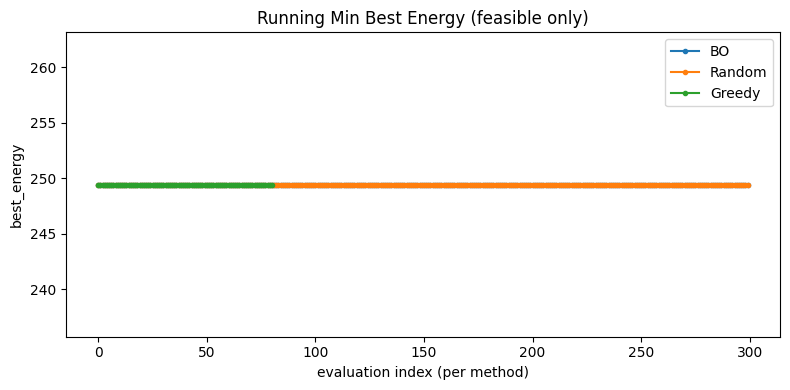

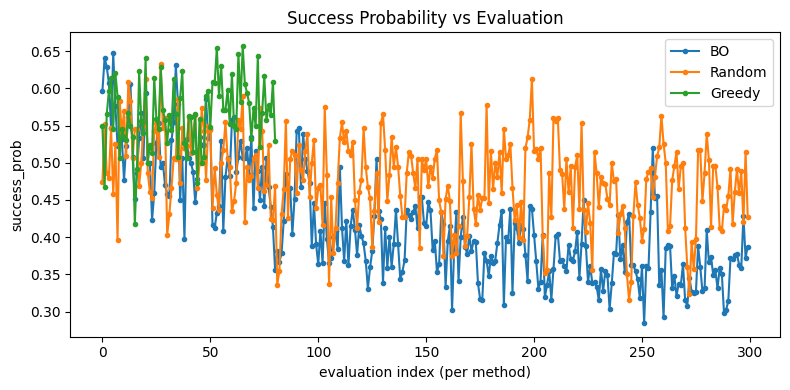

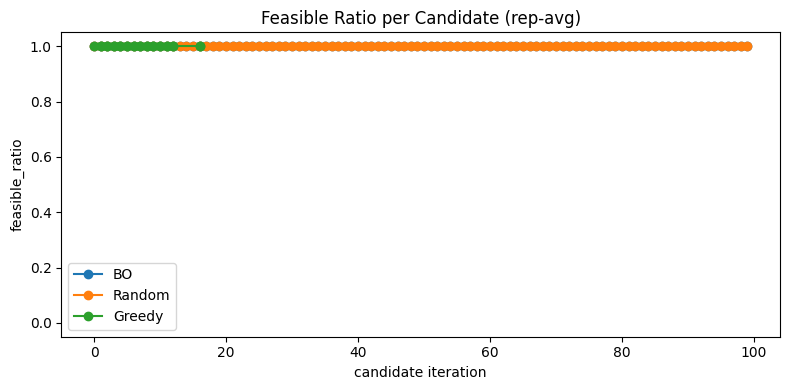

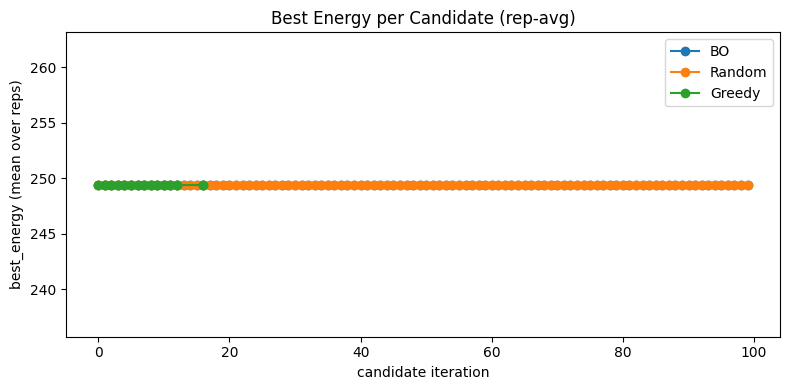

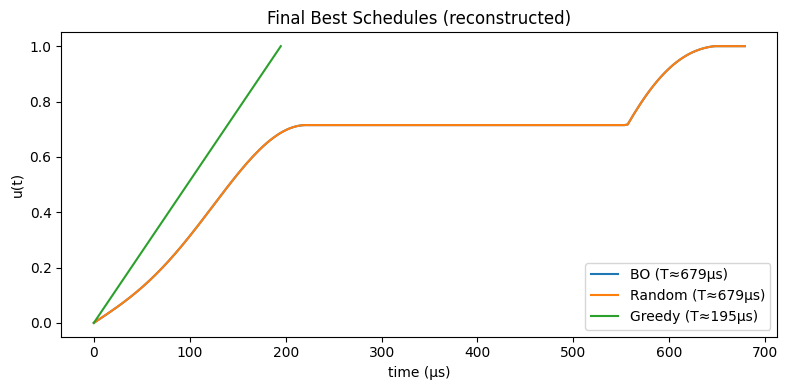

In [39]:
# ============================================================
# Unified comparator: Bayesian Optimization + Random + Greedy
# - Common utilities (feasibility, TSP penalty, eval, schedule)
# - Three optimizers: BO / RS / GS
# - Runs all three, saves logs, prints summaries, and plots comparisons
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace

# ----- skopt (for BO) -----
try:
    from skopt import gp_minimize
    from skopt.space import Real
    from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
    from skopt.learning import GaussianProcessRegressor
    SKOPT_AVAILABLE = True
except Exception as e:
    SKOPT_AVAILABLE = False
    _SKOPT_ERR = e

# -----------------------------
# 0) Feasibility helpers
# -----------------------------
def build_feasibility_fn_linear(eq=None, le=None, ge=None, tol=0.0):
    eq = eq or []; le = le or []; ge = ge or []
    def feas(sample, variables):
        assign = {v: int(sample[i]) for i, v in enumerate(variables)}
        for c in eq:
            lhs = sum(c['lhs'].get(v, 0.0) * assign.get(v, 0) for v in c['lhs'])
            if abs(lhs - c['rhs']) > c.get('tol', tol):
                return False
        for c in le:
            lhs = sum(c['lhs'].get(v, 0.0) * assign.get(v, 0) for v in c['lhs'])
            if (lhs - c['rhs']) > c.get('tol', tol):
                return False
        for c in ge:
            lhs = sum(c['lhs'].get(v, 0.0) * assign.get(v, 0) for v in c['lhs'])
            if (c['rhs'] - lhs) > c.get('tol', tol):
                return False
        return True
    return feas

def build_feasibility_fn_penalty(penalty_eval_fn, eps_abs=0.5, eps_rel=0.0, lam_sum=1.0):
    thr = float(eps_abs + eps_rel * abs(lam_sum))
    def feas(sample, variables):
        p = float(penalty_eval_fn(sample, variables))
        return (p <= thr)
    return feas

# ---------------------------------------------------------
# 1) TSP(포지션 기반 x_{i,j}) 전용 유틸
# ---------------------------------------------------------
def build_penalty_tsp_perm(n, var_name_fmt="x_{i}_{j}", forbid_edges=None,
                           w_row=1, w_col=1, w_forbid=2):
    forbid_edges = set(forbid_edges or [])
    def penalty_eval(sample, variables):
        idx = {v:k for k,v in enumerate(variables)}
        X = np.zeros((n,n), dtype=int)
        for i in range(n):
            for j in range(n):
                name = var_name_fmt.format(i=i, j=j)
                k = idx.get(name)
                if k is not None:
                    X[i, j] = int(sample[k])
        row_viols = (X.sum(axis=1) - 1)
        p_row = int(np.sum(row_viols * row_viols))
        col_viols = (X.sum(axis=0) - 1)
        p_col = int(np.sum(col_viols * col_viols))
        return w_row * p_row + w_col * p_col
    return penalty_eval

def decode_tour_from_X(sample, variables, n, var_name_fmt="x_{i}_{j}"):
    idx = {v:k for k,v in enumerate(variables)}
    tour = []
    for j in range(n):
        city = None
        for i in range(n):
            name = var_name_fmt.format(i=i, j=j)
            k = idx.get(name)
            if k is not None and int(sample[k]) == 1:
                city = i; break
        if city is None: return None
        tour.append(city)
    return tour

def tour_length(tour, dist):
    n = len(tour)
    return float(sum(dist[tour[j]][tour[(j+1) % n]] for j in range(n)))

def make_tsp_energy_fn(n, distances, var_name_fmt="x_{i}_{j}",
                       feasibility_fn=None, bigM=1e9):
    def energy_calc(sample, variables, _unused=None):
        if feasibility_fn is not None and not feasibility_fn(sample, variables):
            return float(bigM)
        tour = decode_tour_from_X(sample, variables, n, var_name_fmt)
        if tour is None: return float(bigM)
        return tour_length(tour, distances)
    return energy_calc

# ---------------------------------------------------------
# 2) 스케줄/시간 예산/평가
# ---------------------------------------------------------
def cap_reads_for_qpu(T_us, reads_req,
                      qpu_time_limit_us=990_000,
                      readout_us=130, per_read_overhead_us=20,
                      programming_overhead_us=20_000):
    per_read_us = max(1.0, T_us + readout_us + per_read_overhead_us)
    budget = max(1.0, qpu_time_limit_us - programming_overhead_us)
    max_reads = int(max(1, np.floor(budget / per_read_us)))
    return int(min(reads_req, max_reads))

def make_fourier_schedule(T_us, thetas, n_point=201, enforce_monotone=True):
    T = float(T_us)
    thetas = np.asarray(thetas, dtype=float)
    t = np.linspace(0.0, T, int(n_point))
    u = t / T
    for j, theta_j in enumerate(thetas, start=1):
        u += theta_j * np.sin(j * np.pi * t / T)
    u = np.clip(u, 0.0, 1.0)
    if enforce_monotone: u = np.maximum.accumulate(u)
    return list(zip(t.tolist(), u.tolist()))

def evaluate_schedule_with_qpu(
    bqm, sampler, distances, n_point,
    schedule, reads, Q=0.99, chain_strength=None,
    objective_mode='energy',
    feasibility_fn=None,
    energy_calc_fn=None,
    cbf_from_embedding=True
):
    def _sample_with_schedule():
        try:
            chain_break_fraction=True
            return sampler.sample(bqm, num_reads=reads, anneal_schedule=schedule, chain_strength=chain_strength,chain_break_fraction=True)
        except TypeError:
            try:
                return sampler.sample(bqm, num_reads=reads)
            except Exception:
                return None
        except Exception:
            return None

    sampleset = _sample_with_schedule()
    if sampleset is None: return None

    # chain-break fraction
    cbf = None
    rec_names = sampleset.record.dtype.names
    if rec_names and ('chain_break_fraction' in rec_names):
        cbf = sampleset.record['chain_break_fraction'].astype(float)
    elif cbf_from_embedding:
        emb = sampleset.info.get('embedding_context', {}).get('embedding', None)
        if emb is not None:
            var_to_idx = {v: i for i, v in enumerate(sampleset.variables)}
            arr = sampleset.record['sample']
            n_chains = max(len(emb), 1)
            cbf_vals = []
            for s in arr:
                broken = 0
                for chain in emb.values():
                    idxs = [var_to_idx[q] for q in chain if q in var_to_idx]
                    if len(idxs) == 0: continue
                    vals = s[idxs]
                    if not np.all(vals == vals[0]): broken += 1
                cbf_vals.append(broken / n_chains)
            cbf = np.asarray(cbf_vals, dtype=float)
    cbf_mean = float(np.mean(cbf)) if (cbf is not None and len(cbf)) else float('nan')
    cbf_std  = float(np.std(cbf))  if (cbf is not None and len(cbf)) else float('nan')

    # feasible mask
    if feasibility_fn is None:
        feasible_mask = np.ones(len(sampleset), dtype=bool)
    else:
        feasible_mask = np.array([bool(feasibility_fn(s, sampleset.variables))
                                  for s in sampleset.record['sample']], dtype=bool)
    success_prob = float(np.mean(feasible_mask)) if len(feasible_mask) else 0.0
    done = bool(np.any(feasible_mask))

    # energies
    raw_energies = sampleset.record['energy'].astype(float)
    if energy_calc_fn is not None:
        dom_energies = np.array([float(energy_calc_fn(s, sampleset.variables, distances))
                                 for s in sampleset.record['sample']], dtype=float)
    else:
        dom_energies = raw_energies.copy()

    if done:
        best_energy = float(np.min(dom_energies[feasible_mask]))
    else:
        best_energy = float(np.min(dom_energies))

    return SimpleNamespace(
        best_energy=best_energy,
        success_prob=success_prob,
        cbf_mean=cbf_mean,
        cbf_std=cbf_std,
        done=done,
        schedule=schedule,
        params={},
        tts=None,
        _raw_energies=raw_energies,
        _dom_energies=dom_energies,
        _feasible_mask=feasible_mask
    )

# ---------------------------------------------------------
# 3) Random Search (Fourier)
# ---------------------------------------------------------
def random_optimize_anneal_schedule_fourier(
    bqm, sampler, distances, n_point,
    n_calls=36,
    reads_low=250, reads_high=900, n_rep=3,
    objective_mode='energy',
    T_bounds=(20.0, 1900.0),
    n_harmonics=4,
    chain_strength=None, Q=0.99, random_state=42,
    enforce_monotone=True,
    return_history=True,
    feasibility_fn=None,
    energy_calc_fn=None,
    verbose=True, print_every=1
):
    rng = np.random.default_rng(random_state)
    T_low, T_high = map(float, T_bounds)

    def _is_better(a, b, mode):
        if a is None: return False
        if b is None: return True
        if mode == 'tts': return (a.tts is not None and b.tts is not None and a.tts < b.tts)
        elif mode == 'success': return a.success_prob > b.success_prob
        else: return a.best_energy < b.best_energy

    def _sample_candidate():
        T_us = float(np.exp(np.log(T_low) + rng.random()*(np.log(T_high) - np.log(T_low))))
        thetas = [rng.uniform(-1.0/j, 1.0/j) for j in range(1, n_harmonics+1)]
        return [T_us] + thetas

    best, first_sched = None, None
    eval_log, cache = [], {}

    for it in range(n_calls):
        reads_now = int(round(reads_low + (reads_high - reads_low) * (it / max(n_calls-1, 1))))
        x = _sample_candidate()
        key = tuple(np.round(x, 6))
        if key in cache: continue

        T_us, thetas = float(x[0]), [float(v) for v in x[1:]]
        sched = make_fourier_schedule(T_us, thetas, n_point=n_point, enforce_monotone=enforce_monotone)
        if first_sched is None: first_sched = sched

        reads_eff = cap_reads_for_qpu(T_us, reads_now)
        vals, local_best = [], None

        for rep in range(n_rep):
            try:
                res = evaluate_schedule_with_qpu(
                    bqm, sampler, distances, n_point,
                    schedule=sched, reads=reads_eff, Q=Q,
                    chain_strength=chain_strength, objective_mode=objective_mode,
                    feasibility_fn=feasibility_fn, energy_calc_fn=energy_calc_fn
                )
            except Exception as e:
                if verbose and (it % print_every == 0):
                    print(f"[WARN][Random] eval fail @iter={it}, rep={rep+1}: {e}")
                res = None

            if res is None:
                obj_val = 1e12
                vals.append(obj_val)
                eval_log.append({"iter": it, "rep": rep, "cand_key": key, "reads": reads_eff,
                                 "objective_mode": objective_mode, "obj_val": obj_val,
                                 "best_energy": np.nan, "success_prob": np.nan,
                                 "cbf_mean": np.nan, "cbf_std": np.nan, "feasible": False,
                                 "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})
                continue

            if objective_mode == 'tts': obj_val = res.tts if res.tts is not None else 1e12
            elif objective_mode == 'success': obj_val = -res.success_prob
            else: obj_val = res.best_energy
            vals.append(obj_val)

            if _is_better(res, best, objective_mode): best = res
            if _is_better(res, local_best, objective_mode): local_best = res

            eval_log.append({"iter": it, "rep": rep, "cand_key": key, "reads": reads_eff,
                             "objective_mode": objective_mode, "obj_val": obj_val,
                             "best_energy": getattr(res, "best_energy", np.nan),
                             "success_prob": getattr(res, "success_prob", np.nan),
                             "cbf_mean": getattr(res, "cbf_mean", np.nan),
                             "cbf_std": getattr(res, "cbf_std", np.nan),
                             "feasible": bool(getattr(res, "done", True)),
                             "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})

        cache[key] = (np.mean(vals), np.std(vals), local_best)
        if verbose and (it % print_every == 0):
            print(f"[Random] iter={it:02d}  mean_obj={np.mean(vals):.4g}  reads={reads_eff}")

    if best is None: raise RuntimeError("Random search failed to find a valid schedule.")

    if not return_history: return best
    df_eval = pd.DataFrame(eval_log)
    theta_cols = [f"theta_{i+1}" for i in range(n_harmonics)]
    agg_cols = ["obj_val","best_energy","success_prob","cbf_mean","cbf_std","reads","T_us"] + theta_cols
    df_cand = (df_eval.groupby(["iter","cand_key"], as_index=False)[agg_cols+["feasible"]]
                     .mean().rename(columns={"feasible":"feasible_ratio"})
                     .sort_values("iter").reset_index(drop=True))
    return best, df_eval, df_cand, first_sched

# ---------------------------------------------------------
# 4) Greedy Coordinate Search (Fourier)
# ---------------------------------------------------------
def greedy_optimize_anneal_schedule_fourier(
    bqm, sampler, distances, n_point,
    n_calls=36,
    reads_low=250, reads_high=900, n_rep=3,
    objective_mode='energy',
    T_bounds=(20.0, 1900.0),
    n_harmonics=4,
    chain_strength=None, Q=0.99, random_state=7,
    enforce_monotone=True,
    return_history=True,
    feasibility_fn=None,
    energy_calc_fn=None,
    init_mode="center",
    step_T_log=0.35, step_theta=0.25,
    shrink=0.6, min_step_theta=0.02, min_step_T_log=0.05,
    verbose=True, print_every=1
):
    rng = np.random.default_rng(random_state)
    T_low, T_high = map(float, T_bounds)

    def _is_better(a, b, mode):
        if a is None: return False
        if b is None: return True
        if mode == 'tts': return (a.tts is not None and b.tts is not None and a.tts < b.tts)
        elif mode == 'success': return a.success_prob > b.success_prob
        else: return a.best_energy < b.best_energy

    def _clip_thetas(ths):
        return [float(np.clip(th, -1.0/(i+1), 1.0/(i+1))) for i, th in enumerate(ths)]

    # init
    if init_mode == "random":
        T0 = float(np.exp(np.log(T_low) + rng.random()*(np.log(T_high) - np.log(T_low))))
        th0 = [rng.uniform(-1.0/j, 1.0/j) for j in range(1, n_harmonics+1)]
    else:
        T0 = float(np.exp(0.5*(np.log(T_low)+np.log(T_high))))
        th0 = [0.0]*n_harmonics
    th0 = _clip_thetas(th0)

    x_cur = [T0] + th0
    first_sched = make_fourier_schedule(x_cur[0], x_cur[1:], n_point=n_point, enforce_monotone=enforce_monotone)
    best, eval_log, cache = None, [], {}

    def eval_x(x, it, reads_now):
        key = tuple(np.round(x, 6))
        if key in cache: return cache[key]
        T_us, thetas = float(x[0]), _clip_thetas([float(v) for v in x[1:]])
        sched = make_fourier_schedule(T_us, thetas, n_point=n_point, enforce_monotone=enforce_monotone)
        reads_eff = cap_reads_for_qpu(T_us, reads_now)
        vals, local_best = [], None

        for rep in range(n_rep):
            try:
                res = evaluate_schedule_with_qpu(
                    bqm, sampler, distances, n_point,
                    schedule=sched, reads=reads_eff, Q=Q,
                    chain_strength=chain_strength, objective_mode=objective_mode,
                    feasibility_fn=feasibility_fn, energy_calc_fn=energy_calc_fn
                )
            except Exception as e:
                if verbose and (it % print_every == 0):
                    print(f"[WARN][Greedy] eval fail @iter={it}, rep={rep+1}: {e}")
                res = None

            if res is None:
                obj_val = 1e12
                vals.append(obj_val)
                eval_log.append({"iter": it, "rep": rep, "cand_key": key, "reads": reads_eff,
                                 "objective_mode": objective_mode, "obj_val": obj_val,
                                 "best_energy": np.nan, "success_prob": np.nan,
                                 "cbf_mean": np.nan, "cbf_std": np.nan, "feasible": False,
                                 "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})
                continue

            if objective_mode == 'tts': obj_val = res.tts if res.tts is not None else 1e12
            elif objective_mode == 'success': obj_val = -res.success_prob
            else: obj_val = res.best_energy
            vals.append(obj_val)

            nonlocal best
            if _is_better(res, best, objective_mode): best = res
            if _is_better(res, local_best, objective_mode): local_best = res

            eval_log.append({"iter": it, "rep": rep, "cand_key": key, "reads": reads_eff,
                             "objective_mode": objective_mode, "obj_val": obj_val,
                             "best_energy": getattr(res, "best_energy", np.nan),
                             "success_prob": getattr(res, "success_prob", np.nan),
                             "cbf_mean": getattr(res, "cbf_mean", np.nan),
                             "cbf_std": getattr(res, "cbf_std", np.nan),
                             "feasible": bool(getattr(res, "done", True)),
                             "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})

        out = (np.mean(vals), np.std(vals), local_best)
        cache[key] = out
        return out

    # evaluate init
    eval_x(x_cur, it=0, reads_now=reads_low)

    cur_step_T = float(step_T_log)
    cur_step_th = float(step_theta)
    coord_order = list(range(0, 1 + n_harmonics))
    it = 1
    while it < n_calls and (cur_step_T >= min_step_T_log or cur_step_th >= min_step_theta):
        reads_now = int(round(reads_low + (reads_high - reads_low) * (it / max(n_calls-1, 1))))
        coord = coord_order[(it-1) % len(coord_order)]

        candidates = []
        if coord == 0:
            logT = np.log(x_cur[0])
            for sgn in (+1, -1):
                T_new = float(np.exp(np.clip(logT + sgn*cur_step_T, np.log(T_low), np.log(T_high))))
                candidates.append([T_new] + x_cur[1:])
        else:
            j = coord - 1
            for sgn in (+1, -1):
                th_new = x_cur[1:].copy()
                th_new[j] = float(th_new[j] + sgn*cur_step_th)
                th_new = _clip_thetas(th_new)
                candidates.append([x_cur[0]] + th_new)
        candidates.append(x_cur)

        scores = []
        for x_try in candidates:
            mean_val, std_val, _ = eval_x(x_try, it=it, reads_now=reads_now)
            scores.append((mean_val, std_val, x_try))
        scores.sort(key=lambda z: z[0])
        best_mean, _, best_x = scores[0]
        cur_mean = [s for s in scores if s[2] is x_cur][0][0]
        improved = (best_mean < cur_mean - 1e-12)

        if improved:
            x_cur = best_x
            if verbose and (it % print_every == 0):
                print(f"[Greedy] iter={it:02d} coord={coord} improved: {cur_mean:.4g} -> {best_mean:.4g}  stepT={cur_step_T:.3f} stepθ={cur_step_th:.3f}")
        else:
            if coord == 0 and cur_step_T >= min_step_T_log: cur_step_T *= shrink
            if coord > 0 and cur_step_th >= min_step_theta: cur_step_th *= shrink
            if verbose and (it % print_every == 0):
                print(f"[Greedy] iter={it:02d} coord={coord} no-improve → shrink  stepT={cur_step_T:.3f} stepθ={cur_step_th:.3f}")
        it += 1

    if best is None: raise RuntimeError("Greedy search failed to find a valid schedule.")

    if not return_history: return best
    df_eval = pd.DataFrame(eval_log)
    theta_cols = [f"theta_{i+1}" for i in range(n_harmonics)]
    agg_cols = ["obj_val","best_energy","success_prob","cbf_mean","cbf_std","reads","T_us"] + theta_cols
    df_cand = (df_eval.groupby(["iter","cand_key"], as_index=False)[agg_cols+["feasible"]]
                     .mean().rename(columns={"feasible":"feasible_ratio"})
                     .sort_values("iter").reset_index(drop=True))
    return best, df_eval, df_cand, first_sched

# ---------------------------------------------------------
# 5) BO main (Fourier) - from your code
# ---------------------------------------------------------
def bo_optimize_anneal_schedule_fourier(
    bqm, sampler, distances, n_point,
    n_calls=32, n_initial_points=8,
    reads_low=250, reads_high=800, n_rep=3,
    objective_mode='tts',
    T_bounds=(20.0, 1900.0),
    n_harmonics=4,
    xi_start=0.05, xi_end=0.005,
    gp_alpha=1e-6, gp_noise_lb=1e-6, gp_n_restarts=6,
    chain_strength=None, Q=0.99, random_state=123,
    trust_region=True, tr_shrink_every=8, tr_shrink_ratio=0.75,
    enforce_monotone=True,
    return_history=False,
    feasibility_fn=None,
    energy_calc_fn=None,
    verbose=False, print_every=1
):
    if not SKOPT_AVAILABLE:
        raise ImportError(f"scikit-optimize(skopt) not available: {_SKOPT_ERR}")

    rng = np.random.default_rng(random_state)
    T_low, T_high = T_bounds

    best = None
    tr_center_T = 0.5 * (T_low + T_high)
    no_improve_ctr = 0
    cache = {}
    eval_log = []
    first_sched = None

    # Search space
    space = [Real(T_low, T_high, name="T_us", prior="log-uniform")]
    for j in range(1, n_harmonics + 1):
        space.append(Real(-1.0/j, 1.0/j, name=f"theta_{j}"))

    # GP surrogate
    length_scales = [0.4] * (1 + n_harmonics)
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=length_scales, nu=2.5) \
             + WhiteKernel(noise_level=1e-2, noise_level_bounds=(gp_noise_lb, 1e+1))
    base_est = GaussianProcessRegressor(
        kernel=kernel, alpha=gp_alpha, normalize_y=True,
        n_restarts_optimizer=gp_n_restarts, random_state=random_state
    )

    def _is_better(a, b, mode):
        if a is None: 
            return False
        if b is None: 
            return True
    
        # 수치 안정적 동률 기준
        def _close(x, y):
            # 에너지 규모에 비례한 상대/절대 오차 허용
            atol = 1e-6
            rtol = 1e-5
            return abs(x - y) <= max(atol, rtol * max(abs(x), abs(y)))
    
        if mode == 'tts':
            return (a.tts is not None and b.tts is not None and a.tts < b.tts)
    
        elif mode == 'success':
            if a.success_prob > b.success_prob + 1e-12:
                return True
            if _close(a.success_prob, b.success_prob):
                # ★ 동률이면 T가 더 작은 쪽
                Ta = float(a.schedule[-1][0]); Tb = float(b.schedule[-1][0])
                return Ta < Tb
            return False
    
        else:  # 'energy'
            if a.best_energy < b.best_energy - 1e-12:
                return True
            if _close(a.best_energy, b.best_energy):
                # ★ 동률이면 T가 더 작은 쪽을 선택
                Ta = float(a.schedule[-1][0]); Tb = float(b.schedule[-1][0])
                return Ta < Tb
            return False


    def eval_tuple(theta_vec, reads_for_this_iter, iter_idx):
        nonlocal best, first_sched, tr_center_T
        T_us = float(theta_vec[0])
        thetas = [float(v) for v in theta_vec[1:]]
        thetas = [float(np.clip(th, -1.0/(i+1), 1.0/(i+1))) for i, th in enumerate(thetas)]

        sched = make_fourier_schedule(T_us, thetas, n_point=n_point, enforce_monotone=enforce_monotone)
        if first_sched is None: first_sched = sched

        vals, local_best = [], None
        cand_key = tuple(np.round([T_us] + thetas, 6))
        reads_eff = cap_reads_for_qpu(T_us, reads_for_this_iter)

        for rep_idx in range(n_rep):
            try:
                res = evaluate_schedule_with_qpu(
                    bqm, sampler, distances, n_point,
                    schedule=sched, reads=reads_eff, Q=Q,
                    chain_strength=chain_strength, objective_mode=objective_mode,
                    feasibility_fn=feasibility_fn, energy_calc_fn=energy_calc_fn
                )
            except Exception as e:
                if verbose and (iter_idx % print_every == 0):
                    print(f"[WARN] sampler/eval failed at iter={iter_idx}, rep={rep_idx+1}: {e}")
                res = None

            if res is None:
                obj_val = 1e12
                vals.append(obj_val)
                eval_log.append({"iter": iter_idx, "rep": rep_idx, "cand_key": cand_key, "reads": reads_eff,
                                 "objective_mode": objective_mode, "obj_val": obj_val,
                                 "best_energy": np.nan, "success_prob": np.nan,
                                 "cbf_mean": np.nan, "cbf_std": np.nan, "feasible": False,
                                 "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})
                continue

            if verbose and (iter_idx % print_every == 0):
                raw_best = float(np.min(getattr(res, "_raw_energies", np.array([np.nan]))))
                dom_best = float(np.min(getattr(res, "_dom_energies", np.array([np.nan]))))
                cbf_m, cbf_s = getattr(res, "cbf_mean", np.nan), getattr(res, "cbf_std", np.nan)
                print("---- Evaluation Result ----")
                print(f"iter={iter_idx:02d}, rep={rep_idx+1}/{n_rep}, reads={reads_eff}")
                print(f"best_energy(raw): {raw_best}")
                print(f"feasible?: {res.done}")
                print(f"domain best (tour): {dom_best}")
                print(f"success_prob: {res.success_prob}")
                print(f"CBF mean±std: {cbf_m:.3f}±{cbf_s:.3f}")
                print("--------------------------------")

            if objective_mode == 'tts': obj_val = res.tts if res.tts is not None else 1e12
            elif objective_mode == 'success': obj_val = -res.success_prob
            else: obj_val = res.best_energy
            vals.append(obj_val)

            if _is_better(res, best, objective_mode):
                best = res; tr_center_T = T_us
            if _is_better(res, local_best, objective_mode):
                local_best = res

            eval_log.append({"iter": iter_idx, "rep": rep_idx, "cand_key": cand_key, "reads": reads_eff,
                             "objective_mode": objective_mode, "obj_val": obj_val,
                             "best_energy": getattr(res, "best_energy", np.nan),
                             "success_prob": getattr(res, "success_prob", np.nan),
                             "cbf_mean": getattr(res, "cbf_mean", np.nan),
                             "cbf_std": getattr(res, "cbf_std", np.nan),
                             "feasible": bool(getattr(res, "done", True)),
                             "T_us": T_us, **{f"theta_{i+1}": thetas[i] for i in range(len(thetas))}})

        return np.mean(vals), np.std(vals), local_best

    def make_objective(iter_idx):
        xi_now = float(xi_start + (xi_end - xi_start) * (iter_idx / max(n_calls - 1, 1)))
        reads_now = int(round(reads_low + (reads_high - reads_low) * (iter_idx / max(n_calls - 1, 1))))
        def objective(x):
            nonlocal no_improve_ctr, best
            key = tuple(np.round(x, 6))
            if key in cache: return cache[key][0]
            mean_val, std_val, local_best = eval_tuple(x, reads_for_this_iter=reads_now, iter_idx=iter_idx)
            cache[key] = (mean_val, std_val, local_best)
            if local_best is not None and best is not None and _is_better(local_best, best, objective_mode):
                no_improve_ctr = 0
            else:
                no_improve_ctr += 1
            return mean_val
        objective.xi_now = xi_now
        return objective

    cur_T_low, cur_T_high = T_low, T_high
    for it in range(n_calls):
        if trust_region and it > 0 and no_improve_ctr > 0 and (it % tr_shrink_every == 0):
            width = (cur_T_high - cur_T_low) * tr_shrink_ratio
            T_center = float(tr_center_T)
            cur_T_low  = max(T_low,  T_center - width / 2)
            cur_T_high = min(T_high, T_center + width / 2)

        space_dyn = [Real(cur_T_low, cur_T_high, name="T_us", prior="log-uniform")]
        for j in range(1, n_harmonics + 1):
            space_dyn.append(Real(-1.0/j, 1.0/j, name=f"theta_{j}"))
        objective = make_objective(it)
        try:
            gp_minimize(
                objective, space_dyn,
                base_estimator=base_est,
                acq_func="EI", acq_optimizer="auto",
                n_calls=1,
                n_initial_points=0 if it > 0 else n_initial_points,
                random_state=random_state + it,
                xi=objective.xi_now
            )
        except Exception:
            # fallback: one random shot
            x_rand = [float(np.exp(np.log(cur_T_low) + rng.random()*(np.log(cur_T_high) - np.log(cur_T_low))))]
            for j in range(1, n_harmonics + 1):
                x_rand.append(rng.uniform(-1.0/j, 1.0/j))
            _ = objective(x_rand); continue

    if best is None: raise RuntimeError("BO-Fourier failed to find a valid schedule.")

    if not return_history: return best
    df_eval = pd.DataFrame(eval_log)
    theta_cols = [f"theta_{i+1}" for i in range(n_harmonics)]
    agg_cols = ["obj_val","best_energy","success_prob","cbf_mean","cbf_std","reads","T_us"] + theta_cols
    df_cand = (df_eval.groupby(["iter","cand_key"], as_index=False)[agg_cols+["feasible"]]
                     .mean().rename(columns={"feasible":"feasible_ratio"})
                     .sort_values("iter").reset_index(drop=True))
    return best, df_eval, df_cand, first_sched

# ---------------------------------------------------------
# 6) Save helper (BO/RS/GS 공통)
# ---------------------------------------------------------
def save_logs(df_eval, df_cand, tag, prefix):
    df_eval.to_csv(f"{prefix}_eval_log.txt", sep="\t", index=False)
    df_cand.to_csv(f"{prefix}_cand_log.txt", sep="\t", index=False)
    if "reads" in df_eval.columns:
        df_eval["reads"].to_csv(f"reads_{prefix}_{tag}.txt", index=False, header=True)
    if "reads" in df_cand.columns:
        df_cand["reads"].to_csv(f"reads_cand_{prefix}_{tag}.txt", index=False, header=True)
    best_idx  = df_cand["obj_val"].idxmin()
    best_iter = int(df_cand.loc[best_idx, "iter"])
    best_key  = df_cand.loc[best_idx, "cand_key"]
    final_reads = int(df_eval.loc[(df_eval["iter"]==best_iter) & (df_eval["cand_key"]==best_key), "reads"].iloc[0])
    pd.Series([final_reads], name="final_reads").to_csv(f"final_reads_{prefix}_{tag}.txt", index=False, header=True)
    print(f"[{prefix}] Final num_reads =", final_reads)
    for col in ["best_energy","success_prob","cbf_mean","cbf_std","feasible"]:
        if col in df_eval.columns:
            df_eval[col].to_csv(f"{col}_{prefix}_{tag}.txt", index=False, header=True)
    for col in ["best_energy","success_prob","cbf_mean","cbf_std","feasible_ratio"]:
        if col in df_cand.columns:
            df_cand[col].to_csv(f"{col}_cand_{prefix}_{tag}.txt", index=False, header=True)

# ---------------------------------------------------------
# 7) Compare runner (runs all three)
# ---------------------------------------------------------
# ---- 필수 전역 체크 ----
_missing = [nm for nm in ["pyqubo_bqm","sampler","distances","n_point"] if nm not in globals()]
if _missing:
    raise RuntimeError("다음 전역 변수가 필요합니다: " + ", ".join(_missing))

# ---- 세팅 ----
N = int(n_point)
VAR_FMT = "c[{i}][{j}]"    # PyQUBO 변수명 포맷
FORBIDDEN = None

penalty_fn = build_penalty_tsp_perm(n=N, var_name_fmt=VAR_FMT, forbid_edges=FORBIDDEN, w_row=1, w_col=1, w_forbid=2)
feasibility_fn = build_feasibility_fn_penalty(penalty_eval_fn=penalty_fn, eps_abs=0.5, eps_rel=0.0, lam_sum=1.0)
energy_calc_fn = make_tsp_energy_fn(n=N, distances=distances, var_name_fmt=VAR_FMT, feasibility_fn=feasibility_fn, bigM=1e9)

COMMON_ARGS = dict(
    bqm=pyqubo_bqm,
    sampler=sampler,
    distances=distances,
    n_point=n_point,
    n_calls=100,
    reads_low=250, reads_high=900,
    n_rep=3,
    objective_mode='energy',      # (추천) tts는 None인 구현이라 energy 사용
    T_bounds=(20.0, 1900.0),
    n_harmonics=4,
    chain_strength=None, Q=0.99,
    enforce_monotone=True,
    return_history=True,
    feasibility_fn=feasibility_fn,
    energy_calc_fn=energy_calc_fn
)

# ---- Random ----
rs_best, rs_df_eval, rs_df_cand, rs_init_sched = random_optimize_anneal_schedule_fourier(random_state=42, verbose=True, print_every=1, **COMMON_ARGS)
rs_df_eval["method"] = "rs"; rs_df_cand["method"] = "rs"

# ---- Greedy ----
gs_best, gs_df_eval, gs_df_cand, gs_init_sched = greedy_optimize_anneal_schedule_fourier(random_state=42, init_mode="center",
                                                                                          step_T_log=0.35, step_theta=0.25,
                                                                                          shrink=0.6, min_step_theta=0.02, min_step_T_log=0.05,
                                                                                          verbose=True, print_every=1, **COMMON_ARGS)
gs_df_eval["method"] = "gs"; gs_df_cand["method"] = "gs"

# ---- BO ----
if not SKOPT_AVAILABLE:
    raise ImportError(f"scikit-optimize가 필요합니다. 설치 예: pip install scikit-optimize\n원인: {_SKOPT_ERR}")

bo_best, bo_df_eval, bo_df_cand, bo_init_sched = bo_optimize_anneal_schedule_fourier(random_state=42,
                                                                                      n_initial_points=8,
                                                                                      xi_start=0.05, xi_end=0.005,
                                                                                      gp_alpha=1e-6, gp_noise_lb=1e-6, gp_n_restarts=6,
                                                                                      trust_region=True, tr_shrink_every=8, tr_shrink_ratio=0.75,
                                                                                      verbose=True, print_every=1, **COMMON_ARGS)
bo_df_eval["method"] = "bo"; bo_df_cand["method"] = "bo"

# ---- 저장 (원하면 주석 해제) ----
tag = str(N)
save_logs(rs_df_eval, rs_df_cand, tag, prefix="rs")
save_logs(gs_df_eval, gs_df_cand, tag, prefix="gs")
save_logs(bo_df_eval, bo_df_cand, tag, prefix="bo")

# ---- 요약 프린트 (Best energy / T / Success prob) ----
def _best_row_from(df_eval, df_cand):
    if df_cand is not None and len(df_cand) and "obj_val" in df_cand.columns:
        return df_cand.loc[df_cand["obj_val"].idxmin()]
    dE = df_eval
    if "feasible" in dE.columns: dE = dE[dE["feasible"] == True]
    if len(dE): return dE.iloc[np.nanargmin(dE["best_energy"].values)]
    return None

def print_summary(name, best, df_eval, df_cand):
    row = _best_row_from(df_eval, df_cand)
    E = float(row.get("best_energy", np.nan)) if row is not None else np.nan
    T = float(row.get("T_us", np.nan)) if row is not None else np.nan
    P = float(row.get("success_prob", np.nan)) if row is not None else np.nan
    it = int(row["iter"]) if (row is not None and "iter" in row.index and pd.notna(row["iter"])) else -1
    print(f"[{name}] best_energy={E:.6g}, T={T:.1f} µs, success_prob={P:.3f} (iter {it})")

print_summary("Random", rs_best, rs_df_eval, rs_df_cand)
print_summary("Greedy", gs_best, gs_df_eval, gs_df_cand)
print_summary("BO",     bo_best, bo_df_eval, bo_df_cand)

# ---- 비교 플롯 ----
def running_min(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x); cur = np.inf
    for i, v in enumerate(x):
        if np.isfinite(v) and v < cur: cur = v
        out[i] = cur
    return out

# Evaluation-level Running Min Best Energy (feasible only)
plt.figure(figsize=(8,4))
for (df_eval, label) in [(bo_df_eval,"BO"), (rs_df_eval,"Random"), (gs_df_eval,"Greedy")]:
    d = df_eval.copy()
    if "feasible" in d.columns: d = d[d["feasible"]==True]
    d = d[np.isfinite(d["best_energy"])]
    if len(d)==0: continue
    y = running_min(d["best_energy"].values)
    x = np.arange(len(y))
    plt.plot(x, y, marker=".", linestyle="-", label=label)
plt.title("Running Min Best Energy (feasible only)")
plt.xlabel("evaluation index (per method)"); plt.ylabel("best_energy"); plt.legend()
plt.tight_layout(); plt.show()

# Success Probability vs Evaluation
plt.figure(figsize=(8,4))
for (df_eval, label) in [(bo_df_eval,"BO"), (rs_df_eval,"Random"), (gs_df_eval,"Greedy")]:
    d = df_eval
    if "success_prob" not in d.columns or len(d)==0: continue
    y = d["success_prob"].values.astype(float); x = np.arange(len(y))
    plt.plot(x, y, marker=".", linestyle="-", label=label)
plt.title("Success Probability vs Evaluation")
plt.xlabel("evaluation index (per method)"); plt.ylabel("success_prob"); plt.legend()
plt.tight_layout(); plt.show()

# Candidate-level feasible ratio
plt.figure(figsize=(8,4))
for (df_cand, label) in [(bo_df_cand,"BO"), (rs_df_cand,"Random"), (gs_df_cand,"Greedy")]:
    d = df_cand
    if "feasible_ratio" not in d.columns or len(d)==0: continue
    plt.plot(d["iter"].values, d["feasible_ratio"].values, marker="o", linestyle="-", label=label)
plt.title("Feasible Ratio per Candidate (rep-avg)")
plt.xlabel("candidate iteration"); plt.ylabel("feasible_ratio"); plt.ylim(-0.05, 1.05); plt.legend()
plt.tight_layout(); plt.show()

# Candidate mean best_energy
plt.figure(figsize=(8,4))
for (df_cand, label) in [(bo_df_cand,"BO"), (rs_df_cand,"Random"), (gs_df_cand,"Greedy")]:
    d = df_cand
    if "best_energy" not in d.columns or len(d)==0: continue
    plt.plot(d["iter"].values, d["best_energy"].values, marker="o", linestyle="-", label=label)
plt.title("Best Energy per Candidate (rep-avg)")
plt.xlabel("candidate iteration"); plt.ylabel("best_energy (mean over reps)"); plt.legend()
plt.tight_layout(); plt.show()

# 최종 스케줄 곡선 비교 (각 방법의 best candidate로 재구성)
def reconstruct_schedule_row(df_cand):
    if df_cand is None or len(df_cand)==0: return None
    if "obj_val" in df_cand.columns and df_cand["obj_val"].notna().any():
        row = df_cand.loc[df_cand["obj_val"].idxmin()]
    else:
        row = df_cand.loc[df_cand["best_energy"].idxmin()]
    T = float(row.get("T_us", np.nan))
    theta_cols = sorted([c for c in df_cand.columns if c.startswith("theta_")], key=lambda x: int(x.split("_")[1]))
    thetas = [float(row[c]) for c in theta_cols] if theta_cols else []
    return T, thetas

plt.figure(figsize=(8,4))
for (df_cand, label) in [(bo_df_cand,"BO"), (rs_df_cand,"Random"), (gs_df_cand,"Greedy")]:
    rt = reconstruct_schedule_row(df_cand)
    if rt is None: continue
    T, thetas = rt
    t = np.linspace(0, T, 201)
    u = t/T
    for j, th in enumerate(thetas, start=1):
        u += th * np.sin(j*np.pi*t/T)
    u = np.clip(u, 0, 1); u = np.maximum.accumulate(u)
    plt.plot(t, u, label=f"{label} (T≈{T:.0f}µs)")
plt.title("Final Best Schedules (reconstructed)")
plt.xlabel("time (µs)"); plt.ylabel("u(t)"); plt.legend()
plt.tight_layout(); plt.show()
